# Импорт

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from itertools import combinations, chain

from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, RocCurveDisplay, auc

from joblib import dump


# Загружаем датасет и разбиваем её на выборку.

In [3]:
data = pd.read_csv('../../Data/DataLaba2/neo_task_smoted.csv')
X_train, X_test, y_train, y_test = train_test_split(data.drop('hazardous', axis=1), data['hazardous'], test_size=0.85, random_state=42)
X_train.shape, y_train.shape


((24598, 4), (24598,))

In [4]:
data

,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,-0.999187,-0.528599,-0.972789,0.407593,0.0
1,-0.998421,-0.935292,-0.126239,0.290780,0.0
2,-0.997101,-0.534989,0.748307,0.182311,0.0
3,-0.999016,-0.650926,-0.663033,0.374218,0.0
4,-0.992669,-0.430407,0.906601,0.015436,0.0
...,...,...,...,...,...
163987,-0.994367,-0.604209,-0.841236,0.062991,1.0
163988,-0.993778,-0.757087,-0.160396,0.045115,1.0
163989,-0.989685,-0.114495,-0.067884,-0.046048,1.0
163990,-0.986634,-0.067341,0.716200,-0.093033,1.0


# Создаём регрессор.

In [9]:
cbc = CatBoostClassifier(learning_rate=0.05, 
                        task_type="GPU",
                        devices='0:4',
                        logging_level='Silent'
                        )

# Поиск гиппер-параметров.

In [10]:
params = {'depth': np.arange(3, 10), 
          'l2_leaf_reg': np.arange(1, 20),
          'bootstrap_type': ['Bayesian', 'Bernoulli', 'Poisson'],
          # 'leaf_estimation_method': [],
          'num_trees': np.arange(1, 20),
        #   'n_estimators': np.arange(3, 20),
        #   'num_boost_round': np.arange(1, 20),
          }
catboost_classifier_best_params = cbc.randomized_search(params, X=X_train[:1000], y=y_train[:1000], n_iter=3)

catboost_classifier_best_params['params']

0:	loss: 0.4555776	best: 0.4555776 (0)	total: 252ms	remaining: 504ms
1:	loss: 0.4809658	best: 0.4555776 (0)	total: 409ms	remaining: 204ms
2:	loss: 0.4698739	best: 0.4555776 (0)	total: 664ms	remaining: 0us
Estimating final quality...


{'depth': 6, 'l2_leaf_reg': 13, 'iterations': 7, 'bootstrap_type': 'Bayesian'}

In [11]:
cbc.get_all_params()

{'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 'eval_metric': 'Logloss',
 'iterations': 7,
 'leaf_estimation_method': 'Newton',
 'observations_to_bootstrap': 'TestOnly',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'devices': '0:4',
 'eval_fraction': 0,
 'pinned_memory_bytes': '104857600',
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 13,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'gpu_cat_features_storage': 'GpuRam',
 'fold_size_loss_normalization': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': False,
 'meta_l2_frequency': 0,
 'class_names': [0, 1],
 'random_seed': 0,
 'depth': 6,
 'border_count': 128,
 'min_fold_size': 100,
 'data_partition': 'DocParallel',
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'leaf_estimation_backtracking': 'AnyImprovement',

# Обучение.

In [13]:
cbc.fit(X_train, y_train)

# Предсказание.

In [14]:
cbc_predict = cbc.predict(X_test)
cbc_predict

array([1., 0., 1., ..., 0., 1., 0.])

# Оценка

In [17]:
print('Accuracy')
print(accuracy_score(y_test, cbc_predict))

Accuracy
0.8762859233539464


In [18]:
print('Confusion matrix')
print(confusion_matrix(y_test, cbc_predict))

Confusion matrix
[[53195 16539]
 [  706 68954]]


In [19]:
print('Precision, Recall, F\n', classification_report(y_test, cbc_predict))

Precision, Recall, F
               precision    recall  f1-score   support

         0.0       0.99      0.76      0.86     69734
         1.0       0.81      0.99      0.89     69660

    accuracy                           0.88    139394
   macro avg       0.90      0.88      0.87    139394
weighted avg       0.90      0.88      0.87    139394



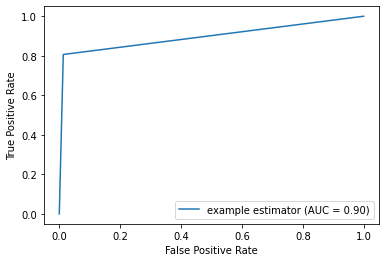

In [20]:
fpr, tpr, thresholds = roc_curve(cbc_predict, y_test)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()